In [18]:
import pandas as pd
import numpy as np
import pvlib
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv('8966199_-23.56_-46.63_2019.csv', header=2)
data['datetime'] = pd.to_datetime(data[['Year','Month', 'Day', 'Hour', 'Minute']])
data['datetime_utc'] = data['datetime'].dt.tz_localize('UTC')
data['datetime_local'] = data['datetime_utc'].dt.tz_convert('America/Sao_Paulo')

# data['datetime'] = data['datetime'].dt.tz_localize(None)
data['dayofyear'] = data['datetime_local'].dt.dayofyear
data = data.iloc[4:]
data.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,Temperature,datetime,datetime_utc,datetime_local,dayofyear
4,2019,1,1,2,0,0,0,0,130.42,2.7,21.1,2019-01-01 02:00:00,2019-01-01 02:00:00+00:00,2019-01-01 00:00:00-02:00,1
5,2019,1,1,2,30,0,0,0,132.42,2.5,21.0,2019-01-01 02:30:00,2019-01-01 02:30:00+00:00,2019-01-01 00:30:00-02:00,1
6,2019,1,1,3,0,0,0,0,133.35,2.4,20.9,2019-01-01 03:00:00,2019-01-01 03:00:00+00:00,2019-01-01 01:00:00-02:00,1
7,2019,1,1,3,30,0,0,0,133.16,2.3,20.7,2019-01-01 03:30:00,2019-01-01 03:30:00+00:00,2019-01-01 01:30:00-02:00,1
8,2019,1,1,4,0,0,0,0,131.85,2.2,20.6,2019-01-01 04:00:00,2019-01-01 04:00:00+00:00,2019-01-01 02:00:00-02:00,1


In [20]:
latitude = -23.55052
longitude = -46.633308
altitude = 590

In [21]:
def classify_day(kt):
    if kt > 0.65:
        return 'Ensolarado'
    elif 0.50 < kt <= 0.65:
        return 'Parcialmente Ensolarado'
    elif 0.35 < kt <= 0.50:
        return 'Parcialmente Nublado'
    else:
        return 'Nublado'

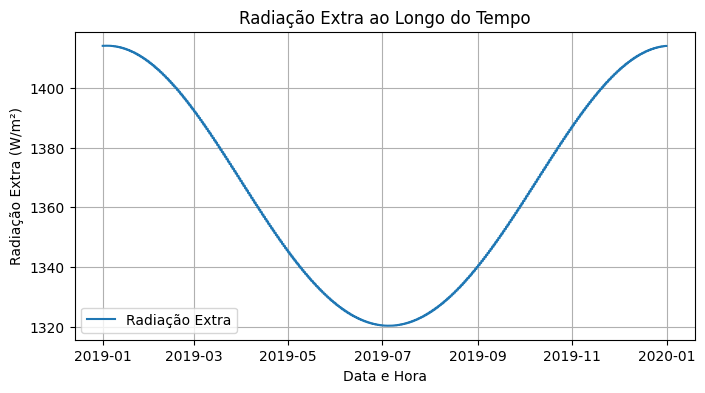

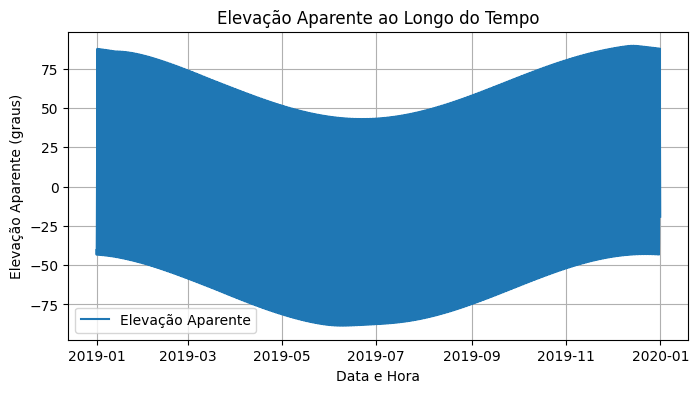

In [22]:
data['datetime_local'] = pd.to_datetime(data['datetime_local'])
datetime_index = pd.DatetimeIndex(data['datetime_local'])

solar_position = pvlib.solarposition.get_solarposition(
    datetime_index,
    latitude,
    longitude,
    altitude=altitude
)

dni_extra = pvlib.irradiance.get_extra_radiation(datetime_index) # Passa um vetor para não precisar do for

plt.figure(figsize=(8, 4))
plt.plot(data['datetime_local'], dni_extra, label='Radiação Extra')
plt.xlabel('Data e Hora')
plt.ylabel('Radiação Extra (W/m²)')
plt.title('Radiação Extra ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(data['datetime_local'], solar_position['apparent_elevation'], label='Elevação Aparente')
plt.xlabel('Data e Hora')
plt.ylabel('Elevação Aparente (graus)')
plt.title('Elevação Aparente ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
solar_position = solar_position.reset_index()
solar_position.head()

,datetime_local,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
0,2019-01-01 00:00:00-02:00,130.431269,130.431269,-40.431269,-40.431269,201.247715,-3.235491
1,2019-01-01 00:30:00-02:00,132.428602,132.428602,-42.428602,-42.428602,192.435013,-3.245391
2,2019-01-01 01:00:00-02:00,133.361499,133.361499,-43.361499,-43.361499,183.099195,-3.255288
3,2019-01-01 01:30:00-02:00,133.166114,133.166114,-43.166114,-43.166114,173.623787,-3.265183
4,2019-01-01 02:00:00-02:00,131.856205,131.856205,-41.856205,-41.856205,164.429482,-3.275076


In [24]:
zenith = solar_position['apparent_zenith']

In [25]:
g0 = np.zeros_like(zenith)

valid_indices = zenith[zenith <= 90].index
print(valid_indices)
for index in valid_indices:
  g0[index] = dni_extra[index] * np.cos(np.radians(zenith[index]))

Index([   13,    14,    15,    16,    17,    18,    19,    20,    21,    22,
       ...
       17502, 17503, 17504, 17505, 17506, 17507, 17508, 17509, 17510, 17511],
      dtype='int64', length=8784)


C:\Users\Marina\AppData\Local\Temp\ipykernel_3464\1203465630.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g0[index] = dni_extra[index] * np.cos(np.radians(zenith[index]))


In [26]:
g0[g0 == 0] = np.nan # substitui por valores vazios que não entram na conta
data['Kt'] = data['GHI'] / g0

In [27]:
data['date'] = data['datetime_local'].dt.date # só o dia respectivo
daily_kt = data.groupby('date')['Kt'].mean()

In [28]:
daily_classification = daily_kt.apply(classify_day)
result_df = pd.DataFrame({'date': daily_classification.index, 'Kt_mean': daily_kt.values, 'classification': daily_classification.values})

In [29]:
result_df.to_csv('classificacao_diaria.csv', index=False)
display(result_df)

,date,Kt_mean,classification
0,2019-01-01,0.435070,Parcialmente Nublado
1,2019-01-02,0.537801,Parcialmente Ensolarado
2,2019-01-03,0.457928,Parcialmente Nublado
3,2019-01-04,0.289591,Nublado
4,2019-01-05,0.198927,Nublado
...,...,...,...
360,2019-12-27,0.620796,Parcialmente Ensolarado
361,2019-12-28,0.583695,Parcialmente Ensolarado
362,2019-12-29,0.572332,Parcialmente Ensolarado
363,2019-12-30,0.661203,Ensolarado


In [37]:
print(result_df['classification'].value_counts())

classification
Parcialmente Ensolarado    134
Nublado                     88
Parcialmente Nublado        83
Ensolarado                  60
Name: count, dtype: int64
